In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import scipy.special as sps
import warnings
import keras.backend as K
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
import tensorflow as tf
import keras

In [3]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras.datasets import mnist

In [4]:
data=pd.read_csv("preprocessed_datasets.csv")

In [5]:
len(data)

2224

In [6]:
#data = data[data.sum_7yr_GP > 0]

In [7]:
len(data)

2224

In [8]:
data.head()

,id,PlayerName,DraftAge,Country,country_group,Height,Weight,Position,DraftYear,Overall,...,rs_PIM,rs_PlusMinus,po_GP,po_G,po_A,po_P,po_PIM,sum_7yr_GP,sum_7yr_TOI,GP_greater_than_0
0,9,David Bornhammar,18,Sweden,EURO,73,198,D,1999,192,...,44,0,0,0,0,0,0,0,0,no
1,27,Yared Hagos,18,Sweden,EURO,73,218,C,2001,70,...,24,1,10,4,1,5,4,0,0,no
2,30,Andreas Jamtin,18,Sweden,EURO,72,194,L,2001,157,...,155,2,0,0,0,0,0,0,0,no
3,58,Per Mars,19,Sweden,EURO,75,216,C,2001,87,...,60,-2,5,1,1,2,4,0,0,no
4,67,Daniel Fernholm,19,Sweden,EURO,76,229,D,2002,101,...,12,29,0,0,0,0,0,0,0,no


In [9]:
draft_year=data["DraftYear"]
# sum_7yr_GP is a target column
sum_7yr_gp_ori=data["sum_7yr_GP"]
data.drop(["id", "PlayerName", "sum_7yr_TOI", "Overall", "GP_greater_than_0","Country"], axis=1, inplace=True)

In [10]:
def standardize(df):
    res = df.copy()
    for i in res.columns:
        mean=np.mean(res[i])
        sd=np.std(res[i])
        if(sd == 0):
             res.drop(i, axis=1, inplace=True)
        else:
             res[i]=(res[i]-mean)/sd
    return res

In [11]:
def insert_1(df):
    res = df.copy()
    res['X'] = 1
    return res

In [12]:
train_set=data[data['DraftYear'].isin([2004,2005,2006])]
test_set=data[data['DraftYear'].isin([2007])]

In [13]:
train_set.head()

,DraftAge,country_group,Height,Weight,Position,DraftYear,CSS_rank,rs_GP,rs_G,rs_A,rs_P,rs_PIM,rs_PlusMinus,po_GP,po_G,po_A,po_P,po_PIM,sum_7yr_GP
36,19,EURO,74,198,D,2004,7,68,9,8,17,54,7,2,0,0,0,4,0
57,18,EURO,73,198,R,2004,70,58,12,15,27,101,1,9,2,2,4,8,0
58,18,EURO,74,192,L,2004,232,31,6,3,9,22,0,9,0,0,0,6,0
59,18,EURO,74,207,L,2004,20,44,4,14,18,16,6,0,0,0,0,0,0
60,19,EURO,75,212,D,2005,250,47,9,16,25,116,1,3,2,1,3,6,0


In [14]:
train_set[train_set.sum_7yr_GP == 0]['sum_7yr_GP'].count() / len(train_set)

0.55729984301412872

In [15]:
test_set[test_set.sum_7yr_GP == 0]['sum_7yr_GP'].count() / len(test_set)

0.52879581151832455

In [16]:
train_set.head()

,DraftAge,country_group,Height,Weight,Position,DraftYear,CSS_rank,rs_GP,rs_G,rs_A,rs_P,rs_PIM,rs_PlusMinus,po_GP,po_G,po_A,po_P,po_PIM,sum_7yr_GP
36,19,EURO,74,198,D,2004,7,68,9,8,17,54,7,2,0,0,0,4,0
57,18,EURO,73,198,R,2004,70,58,12,15,27,101,1,9,2,2,4,8,0
58,18,EURO,74,192,L,2004,232,31,6,3,9,22,0,9,0,0,0,6,0
59,18,EURO,74,207,L,2004,20,44,4,14,18,16,6,0,0,0,0,0,0
60,19,EURO,75,212,D,2005,250,47,9,16,25,116,1,3,2,1,3,6,0


In [17]:
sum_7yr_gp_train=train_set["sum_7yr_GP"]
sum_7yr_gp_test=test_set["sum_7yr_GP"]

In [18]:
sum_7yr_gp_train[sum_7yr_gp_train == 0].count()

355

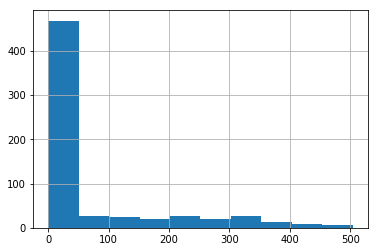

In [19]:
sum_7yr_gp_train.hist()

In [20]:
train_set.drop(['DraftYear',"sum_7yr_GP"], axis=1, inplace=True)
test_set.drop(['DraftYear',"sum_7yr_GP"], axis=1, inplace=True)

In [21]:
train_set = pd.get_dummies(train_set, columns= ['country_group','Position'])
test_set = pd.get_dummies(test_set, columns= ['country_group','Position'])
data.drop(['DraftYear',"sum_7yr_GP"], axis=1, inplace=True)

In [22]:
from sklearn.preprocessing import StandardScaler

# data = [[0, 0], [0, 0], [1, 1], [1, 1]]
scaler = StandardScaler()
scaler.fit(train_set)
scaler_y = StandardScaler()
scaler_y.fit(sum_7yr_gp_train.reshape(-1, 1))


print(scaler.mean_)

train_set_final = scaler.transform(train_set)
test_set_final = scaler.transform(test_set)

#sum_7yr_gp_train = scaler_y.transform(sum_7yr_gp_train.reshape(-1, 1))
#sum_7yr_gp_test = scaler_y.transform(sum_7yr_gp_test.reshape(-1, 1))

[  1.85902669e+01   7.33830455e+01   2.01935636e+02   1.03199372e+02
   5.38320251e+01   1.46907378e+01   2.14536892e+01   3.61428571e+01
   7.02417582e+01   3.07849294e+00   5.54160126e+00   1.35321821e+00
   2.02040816e+00   3.37362637e+00   6.57613815e+00   4.25431711e-01
   3.35949765e-01   2.38618524e-01   2.48037677e-01   3.65777080e-01
   2.02511774e-01   1.83673469e-01]


In [23]:
sum_7yr_gp_train.shape

(637,)

In [24]:
# train_set_final = standardize(train_set)
# test_set_final = standardize(test_set)

In [25]:
#train_set_final = insert_1(train_set_std)
#test_set_final = insert_1(test_set_std)

In [26]:
np.array(train_set_final).shape

(637, 22)

In [27]:
sum_7yr_gp_train[0:5]

36    0
57    0
58    0
59    0
60    0
Name: sum_7yr_GP, dtype: int64

In [28]:
sum_7yr_gp_train = sum_7yr_gp_train.astype('float32')

In [29]:
sum_7yr_gp_train.transpose().shape

(637,)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000FE57B7CCF8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000000FE5BBD8400>]], dtype=object)

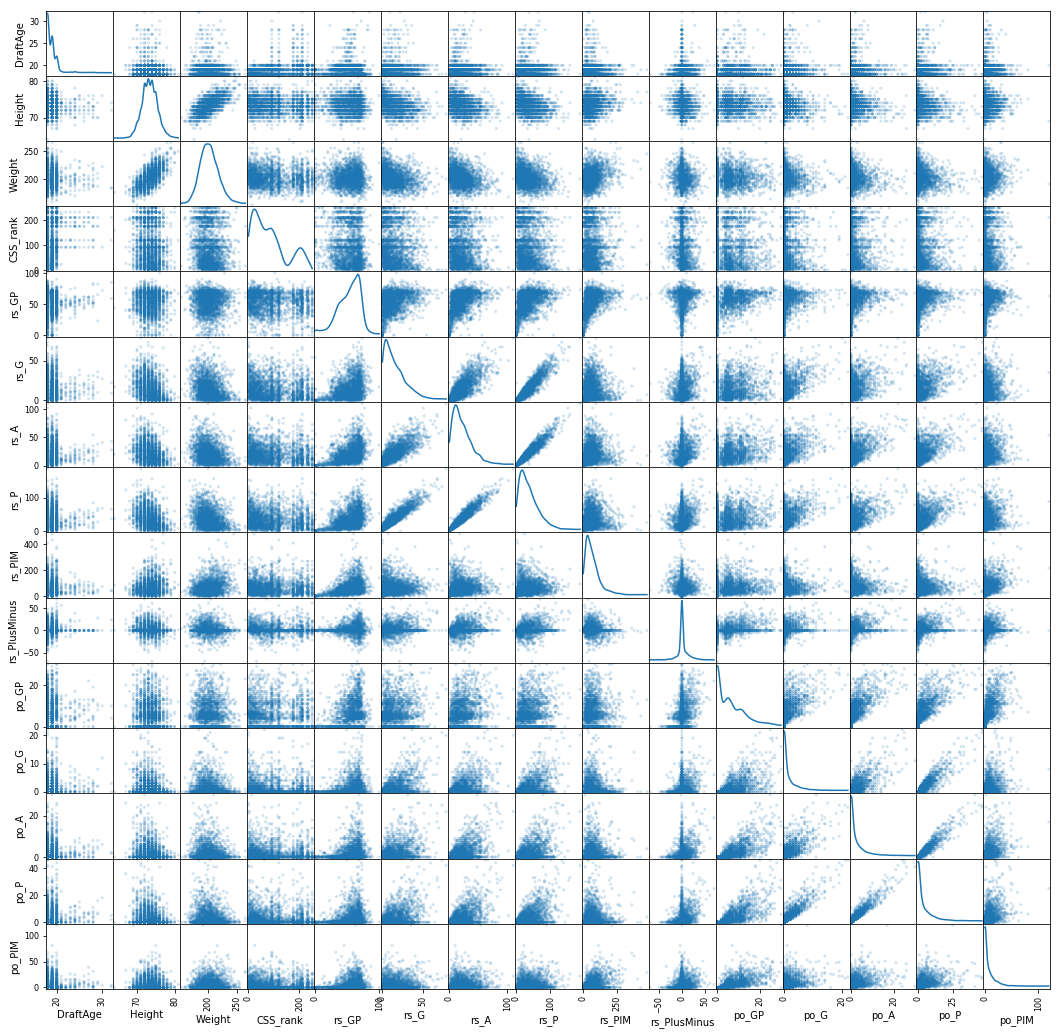

In [30]:
from pandas.plotting import scatter_matrix

# df = pd.DataFrame(np.random.randn(1000, 4), columns=['a', 'b', 'c', 'd'])
# plt.figure(figsize=(18,18))
#scatter_matrix(data, alpha=0.2, figsize=(18, 18), diagonal='kde')

In [31]:
model = Sequential()

def rsquared(y_true, y_pred):
    s_res = K.sum(K.square(y_true - y_pred))
    s_tot = K.sum(K.square(y_true - K.mean(y_true)))
    r2 = 1 - s_res/(s_tot + K.epsilon())
    return(r2)


# model.add(Dense(units=1, activation='relu', input_shape=(22,), kernel_regularizer=keras.regularizers.l2(0.1),
#                 activity_regularizer=keras.regularizers.l2(0.05)))
model.add(Dense(units=2, activation='relu', input_shape=(22,)))
# model.add(Dropout(0.3))
# model.add(Dense(units=1, activation='relu'))
# model.add(Dropout(0.5))
model.add(Dense(units=1, activation='relu'))

# model.add(Dense(units=1, activation='linear', input_shape=(22,)))
# model.add(Dropout(0.8))

sgd = keras.optimizers.SGD(lr=1, momentum=0.9, nesterov=True)
adam = keras.optimizers.Adam()
rmsprop = keras.optimizers.RMSprop(lr=0.001)
model.compile(loss='mse',
              optimizer=adam,
              metrics=[rsquared])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 2)                 46        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 3         
Total params: 49
Trainable params: 49
Non-trainable params: 0
_________________________________________________________________


In [32]:
#val_y = np.expand_dims((sum_7yr_gp_test).transpose(), axis=1)

#val_data = np.concatenate((np.array(test_set_final), val_y), axis=1)

In [33]:
history = model.fit(np.array(train_set_final), sum_7yr_gp_train, epochs=110, 
          batch_size=32, shuffle=True, validation_data=(np.array(test_set_final), sum_7yr_gp_test))

Train on 637 samples, validate on 191 samples
Epoch 1/110
637/637 [==============================] - 0s 459us/step - loss: 17700.4382 - rsquared: -0.3035 - val_loss: 16416.6412 - val_rsquared: -534384860.3029
Epoch 2/110
637/637 [==============================] - 0s 38us/step - loss: 17683.3974 - rsquared: -0.3060 - val_loss: 16392.6972 - val_rsquared: -618315138.5005
Epoch 3/110
637/637 [==============================] - 0s 39us/step - loss: 17664.5305 - rsquared: -0.3075 - val_loss: 16368.2227 - val_rsquared: -717552447.4833
Epoch 4/110
637/637 [==============================] - 0s 41us/step - loss: 17643.7625 - rsquared: -0.3003 - val_loss: 16341.9962 - val_rsquared: -824050672.4032
Epoch 5/110
637/637 [==============================] - 0s 42us/step - loss: 17622.3846 - rsquared: -0.3063 - val_loss: 16314.7887 - val_rsquared: -951703005.6372
Epoch 6/110
637/637 [==============================] - 0s 41us/step - loss: 17599.3573 - rsquared: -0.3074 - val_loss: 16285.5437 - val_rsquare

637/637 [==============================] - 0s 39us/step - loss: 15691.4326 - rsquared: -0.1636 - val_loss: 13982.9868 - val_rsquared: -53937230103.1233
Epoch 51/110
637/637 [==============================] - 0s 36us/step - loss: 15634.1935 - rsquared: -0.1463 - val_loss: 13920.8221 - val_rsquared: -56757088406.4489
Epoch 52/110
637/637 [==============================] - 0s 36us/step - loss: 15578.0506 - rsquared: -0.1542 - val_loss: 13864.3221 - val_rsquared: -59455127981.2304
Epoch 53/110
637/637 [==============================] - 0s 36us/step - loss: 15528.0981 - rsquared: -0.1474 - val_loss: 13793.2904 - val_rsquared: -63035525045.2674
Epoch 54/110
637/637 [==============================] - 0s 38us/step - loss: 15468.6159 - rsquared: -0.1570 - val_loss: 13731.5232 - val_rsquared: -66156526415.3993
Epoch 55/110
637/637 [==============================] - 0s 36us/step - loss: 15413.1310 - rsquared: -0.1430 - val_loss: 13672.2517 - val_rsquared: -69309923842.9973
Epoch 56/110
637/637 [=

637/637 [==============================] - ETA: 0s - loss: 16944.3105 - rsquared: 0.09 - 0s 38us/step - loss: 13344.8316 - rsquared: 0.0045 - val_loss: 11492.7365 - val_rsquared: -291971924654.3856
Epoch 100/110
637/637 [==============================] - 0s 35us/step - loss: 13312.6343 - rsquared: 0.0076 - val_loss: 11456.5741 - val_rsquared: -298948238030.5497
Epoch 101/110
637/637 [==============================] - 0s 36us/step - loss: 13276.2216 - rsquared: 0.0211 - val_loss: 11426.2081 - val_rsquared: -305004911825.2274
Epoch 102/110
637/637 [==============================] - 0s 36us/step - loss: 13242.9301 - rsquared: 0.0123 - val_loss: 11393.4943 - val_rsquared: -311013197405.9573
Epoch 103/110
637/637 [==============================] - 0s 39us/step - loss: 13210.5219 - rsquared: -6.6760e-04 - val_loss: 11361.2827 - val_rsquared: -317173636305.2212
Epoch 104/110
637/637 [==============================] - 0s 38us/step - loss: 13175.1314 - rsquared: 0.0374 - val_loss: 11333.4662 - 

In [34]:
hist_df = pd.DataFrame(history.history)


In [35]:
hist_df.head(3)

,loss,rsquared,val_loss,val_rsquared
0,17700.438242,-0.303480,16416.641239,-5.343849e+08
1,17683.397374,-0.306019,16392.697205,-6.183151e+08
2,17664.530462,-0.307517,16368.222677,-7.175524e+08


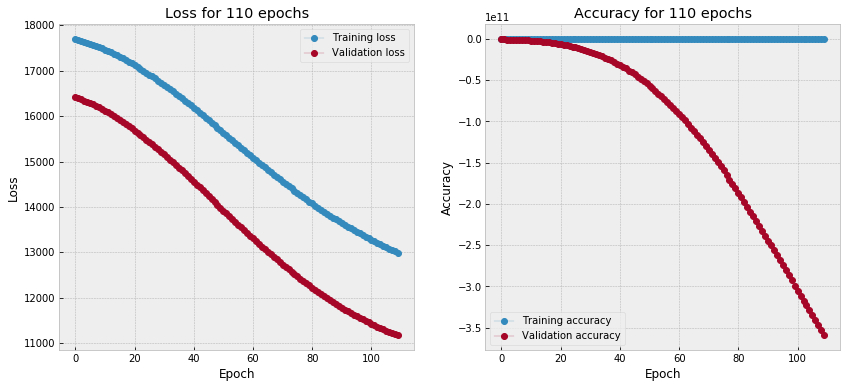

In [36]:
fig = plt.figure(figsize=(14,6))
plt.style.use('bmh')
params_dict = dict(linestyle='solid', linewidth=0.25, marker='o', markersize=6)

plt.subplot(121)
plt.plot(hist_df.loss, label='Training loss', **params_dict)
plt.plot(hist_df.val_loss, label='Validation loss', **params_dict)
plt.title('Loss for ' + str(len(history.epoch)) + ' epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(hist_df.rsquared, label='Training accuracy', **params_dict)
plt.plot(hist_df.val_rsquared, label='Validation accuracy', **params_dict)
plt.title('Accuracy for ' + str(len(history.epoch)) + ' epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

(array([ 268.,  222.,   78.,   44.,   14.,    7.,    2.,    0.,    1.,    1.]),
 array([   1.78257513,   26.19640746,   50.61023979,   75.02407212,
          99.43790445,  123.85173678,  148.26556911,  172.67940145,
         197.09323378,  221.50706611,  245.92089844]),
 <a list of 10 Patch objects>)

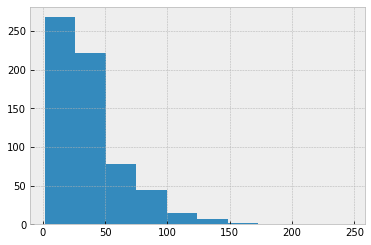

In [37]:
plt.hist(model.predict(np.array(train_set_final)))

(array([ 414.,   19.,   12.,   12.,   11.,    4.,    7.,    5.,    4.,
           7.,    6.,    6.,    3.,    5.,    4.,    5.,    1.,    4.,
           4.,    5.,    7.,    6.,    3.,    4.,    6.,    5.,    7.,
           5.,    1.,    3.,    3.,    8.,    5.,    2.,    8.,    2.,
           5.,    0.,    1.,    4.,    6.,    0.,    1.,    1.,    0.,
           1.,    1.,    3.,    0.,    1.]),
 array([   0.  ,   10.08,   20.16,   30.24,   40.32,   50.4 ,   60.48,
          70.56,   80.64,   90.72,  100.8 ,  110.88,  120.96,  131.04,
         141.12,  151.2 ,  161.28,  171.36,  181.44,  191.52,  201.6 ,
         211.68,  221.76,  231.84,  241.92,  252.  ,  262.08,  272.16,
         282.24,  292.32,  302.4 ,  312.48,  322.56,  332.64,  342.72,
         352.8 ,  362.88,  372.96,  383.04,  393.12,  403.2 ,  413.28,
         423.36,  433.44,  443.52,  453.6 ,  463.68,  473.76,  483.84,
         493.92,  504.  ]),
 <a list of 50 Patch objects>)

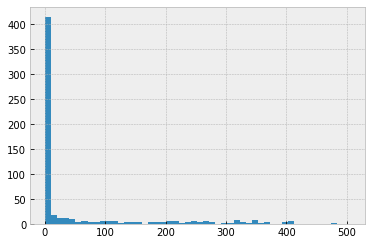

In [38]:
plt.hist(sum_7yr_gp_train, bins=50)

(array([ 268.,  222.,   78.,   44.,   14.,    7.,    2.,    0.,    1.,    1.]),
 array([   273.02859497,   3130.85874329,   5988.6888916 ,   8846.51903992,
         11704.34918823,  14562.17933655,  17420.00948486,  20277.83963318,
         23135.66978149,  25993.49992981,  28851.33007812]),
 <a list of 10 Patch objects>)

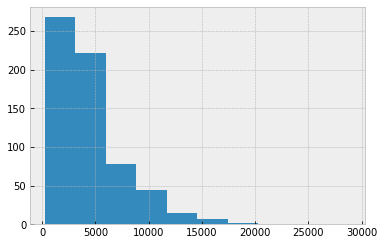

In [39]:
plt.hist(scaler_y.inverse_transform(model.predict(np.array(train_set_final))))

(array([ 414.,   19.,   12.,   12.,   11.,    4.,    7.,    5.,    4.,
           7.,    6.,    6.,    3.,    5.,    4.,    5.,    1.,    4.,
           4.,    5.,    7.,    6.,    3.,    4.,    6.,    5.,    7.,
           5.,    1.,    3.,    3.,    8.,    5.,    2.,    8.,    2.,
           5.,    0.,    1.,    4.,    6.,    0.,    1.,    1.,    0.,
           1.,    1.,    3.,    0.,    1.]),
 array([    64.36420441,   1244.30715469,   2424.25010498,   3604.19305527,
          4784.13600555,   5964.07895584,   7144.02190613,   8323.96485641,
          9503.9078067 ,  10683.85075699,  11863.79370728,  13043.73665756,
         14223.67960785,  15403.62255814,  16583.56550842,  17763.50845871,
         18943.451409  ,  20123.39435928,  21303.33730957,  22483.28025986,
         23663.22321014,  24843.16616043,  26023.10911072,  27203.052061  ,
         28382.99501129,  29562.93796158,  30742.88091187,  31922.82386215,
         33102.76681244,  34282.70976273,  35462.65271301,  36642.59

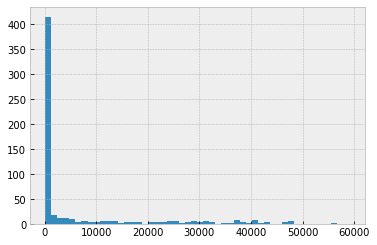

In [40]:
plt.hist(scaler_y.inverse_transform(sum_7yr_gp_train), bins=50)